In [15]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import (
    ResNet50,
    MobileNetV2,
    EfficientNetB0
)


In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0

# Detect project root
CWD = Path().resolve()
if CWD.name == "notebooks":
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

print("Current working dir:", CWD)
print("Assumed project root:", PROJECT_ROOT)

RAW_CLASS_DIR = PROJECT_ROOT / "data" / "classification_dataset"
MODELS_DIR = PROJECT_ROOT / "models" / "classification"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Raw classification dataset:", RAW_CLASS_DIR, "exists:", RAW_CLASS_DIR.exists())

# Check basic structure
for split in ["train", "valid", "test"]:
    for cls in ["bird", "drone"]:
        p = RAW_CLASS_DIR / split / cls
        print(p, "exists:", p.exists())


Current working dir: F:\Aerial_Object_Classification_Detection\notebooks
Assumed project root: F:\Aerial_Object_Classification_Detection
Raw classification dataset: F:\Aerial_Object_Classification_Detection\data\classification_dataset exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\train\bird exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\train\drone exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\valid\bird exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\valid\drone exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\test\bird exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\test\drone exists: True


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

train_dir = RAW_CLASS_DIR / "train"
val_dir   = RAW_CLASS_DIR / "valid"
test_dir  = RAW_CLASS_DIR / "test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",          # integer labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("\nClass names:", class_names)
print("num_classes:", num_classes)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.

Class names: ['bird', 'drone']
num_classes: 2


In [3]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)

print("Datasets are ready (with prefetch).")


Datasets are ready (with prefetch).


In [4]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)


In [5]:
def build_effnet_finetune(input_shape, num_classes, train_base=False):
    """
    EfficientNetB0 with:
    - Input from image_dataset_from_directory: uint8 [0,255]
    - Rescale to [0,1], then augmentation, then [-1,1] for backbone
    """
    inputs = layers.Input(shape=input_shape)

    # 1) Rescale [0,255] -> [0,1]
    x = layers.Rescaling(1./255.0, name="rescale_0_1")(inputs)

    # 2) Data augmentation
    x = data_augmentation(x)

    # 3) Rescale [0,1] -> [-1,1]
    x = layers.Rescaling(2.0, offset=-1.0, name="rescale_minus1_1")(x)

    # 4) Pretrained EfficientNetB0
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base_model.trainable = train_base  # False: frozen for stage1, True: fine-tune in stage2

    # 5) Classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="EfficientNetB0_finetune")
    return model

input_shape = IMG_SIZE + (3,)
model = build_effnet_finetune(input_shape, num_classes, train_base=False)
model.summary()


Model: "EfficientNetB0_finetune"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescale_0_1         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ rescale_0_1[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescale_minus1_1    │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ rescale_minus1_1… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
model.compile(
    loss="sparse_categorical_crossentropy",  # labels are ints from dataset
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

checkpoint_path_stage1 = MODELS_DIR / "transfer_efficientnetb0_stage1_from_folders.h5"

callbacks_stage1 = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath=str(checkpoint_path_stage1),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks_stage1,
    verbose=1
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.5076 - loss: 0.7318
Epoch 1: val_loss improved from None to 0.68260, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_stage1_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.5064 - loss: 0.7253 - val_accuracy: 0.6584 - val_loss: 0.6826
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.5365 - loss: 0.6910
Epoch 2: val_loss did not improve from 0.68260
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 954ms/step - accuracy: 0.5255 - loss: 0.6949 - val_accuracy: 0.5023 - val_loss: 0.6885
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.5395 - loss: 0.6893
Epoch 3: val_loss did not improve from 0.68260
84/84 ━━━━━━━━━━━━━━━━━━━━ 79s 942ms/step - accuracy: 0.5383 - loss: 0.6894 - val_accuracy: 0.5068 - val_loss: 0.6845
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5446 - loss: 0.6891
Epoch 4: val_loss did not improve from 0.68260
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 967ms/step - accuracy: 0.5331 - loss: 0.6899 - val_accuracy: 0.5068 - val_loss: 0.6857
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.5541 - loss: 0.6825
Epoch 5: val_loss improved from 0.68260 to 0.

84/84 ━━━━━━━━━━━━━━━━━━━━ 83s 994ms/step - accuracy: 0.5518 - loss: 0.6859 - val_accuracy: 0.6448 - val_loss: 0.6721
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.5484 - loss: 0.6854
Epoch 6: val_loss improved from 0.67214 to 0.67074, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_stage1_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 83s 994ms/step - accuracy: 0.5466 - loss: 0.6872 - val_accuracy: 0.5950 - val_loss: 0.6707
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.5368 - loss: 0.6878
Epoch 7: val_loss did not improve from 0.67074
84/84 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.5394 - loss: 0.6876 - val_accuracy: 0.5317 - val_loss: 0.6792
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.5628 - loss: 0.6845
Epoch 8: val_loss did not improve from 0.67074
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 961ms/step - accuracy: 0.5530 - loss: 0.6869 - val_accuracy: 0.5747 - val_loss: 0.6754
Epoch 9/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.5563 - loss: 0.6855
Epoch 9: val_loss did not improve from 0.67074
84/84 ━━━━━━━━━━━━━━━━━━━━ 79s 941ms/step - accuracy: 0.5567 - loss: 0.6839 - val_accuracy: 0.5271 - val_loss: 0.6835
Epoch 10/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.5556 - loss: 0.6803
Epoch 10: val_loss did not improve from 0.67

84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5650 - loss: 0.6842 - val_accuracy: 0.7036 - val_loss: 0.6640
Epoch 12/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.5730 - loss: 0.6813
Epoch 12: val_loss did not improve from 0.66396
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 921ms/step - accuracy: 0.5714 - loss: 0.6812 - val_accuracy: 0.6176 - val_loss: 0.6642
Epoch 13/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.5833 - loss: 0.6766
Epoch 13: val_loss improved from 0.66396 to 0.66297, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_stage1_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5710 - loss: 0.6776 - val_accuracy: 0.5882 - val_loss: 0.6630
Epoch 14/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.5695 - loss: 0.6829
Epoch 14: val_loss improved from 0.66297 to 0.65891, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_stage1_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 951ms/step - accuracy: 0.5695 - loss: 0.6809 - val_accuracy: 0.6063 - val_loss: 0.6589
Epoch 15/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.5750 - loss: 0.6778
Epoch 15: val_loss improved from 0.65891 to 0.64702, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_stage1_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5838 - loss: 0.6754 - val_accuracy: 0.6652 - val_loss: 0.6470


In [7]:
# Stage 2: fine-tune EfficientNet top layers
for layer in model.layers:
    layer.trainable = True

# Re-freeze early layers (up to some index)
fine_tune_at = 200  # you can tweak this
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

checkpoint_path_stage2 = MODELS_DIR / "transfer_efficientnetb0_finetuned_from_folders.h5"

callbacks_stage2 = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath=str(checkpoint_path_stage2),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks_stage2,
    verbose=1
)


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5555 - loss: 0.7263
Epoch 1: val_loss improved from None to 0.72187, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5748 - loss: 0.6864 - val_accuracy: 0.5045 - val_loss: 0.7219
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6517 - loss: 0.6302
Epoch 2: val_loss did not improve from 0.72187
84/84 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6544 - loss: 0.6223 - val_accuracy: 0.5068 - val_loss: 0.7246
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6636 - loss: 0.6053
Epoch 3: val_loss improved from 0.72187 to 0.67838, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6653 - loss: 0.6038 - val_accuracy: 0.5452 - val_loss: 0.6784
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6651 - loss: 0.5955
Epoch 4: val_loss improved from 0.67838 to 0.61229, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6694 - loss: 0.5911 - val_accuracy: 0.6380 - val_loss: 0.6123
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6883 - loss: 0.5661
Epoch 5: val_loss improved from 0.61229 to 0.57801, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6863 - loss: 0.5657 - val_accuracy: 0.6810 - val_loss: 0.5780
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6908 - loss: 0.5618
Epoch 6: val_loss improved from 0.57801 to 0.54693, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6905 - loss: 0.5634 - val_accuracy: 0.7511 - val_loss: 0.5469
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6843 - loss: 0.5639
Epoch 7: val_loss did not improve from 0.54693
84/84 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6871 - loss: 0.5595 - val_accuracy: 0.6674 - val_loss: 0.6145
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6878 - loss: 0.5664
Epoch 8: val_loss improved from 0.54693 to 0.52476, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6920 - loss: 0.5604 - val_accuracy: 0.7308 - val_loss: 0.5248
Epoch 9/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7111 - loss: 0.5519
Epoch 9: val_loss did not improve from 0.52476
84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7074 - loss: 0.5495 - val_accuracy: 0.7602 - val_loss: 0.5284
Epoch 10/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7161 - loss: 0.5362
Epoch 10: val_loss did not improve from 0.52476
84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7074 - loss: 0.5487 - val_accuracy: 0.6968 - val_loss: 0.5950
Epoch 11/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7258 - loss: 0.5228
Epoch 11: val_loss did not improve from 0.52476
84/84 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7213 - loss: 0.5251 - val_accuracy: 0.6538 - val_loss: 0.6384
Epoch 12/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7133 - loss: 0.5316
Epoch 12: val_loss improved from 0.52476 to 0.52304, savin

84/84 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7104 - loss: 0.5373 - val_accuracy: 0.7421 - val_loss: 0.5230
Epoch 13/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7189 - loss: 0.5245
Epoch 13: val_loss did not improve from 0.52304
84/84 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7179 - loss: 0.5274 - val_accuracy: 0.5588 - val_loss: 1.4358
Epoch 14/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7014 - loss: 0.5370
Epoch 14: val_loss did not improve from 0.52304
84/84 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7134 - loss: 0.5328 - val_accuracy: 0.7647 - val_loss: 0.5506
Epoch 15/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7207 - loss: 0.5196
Epoch 15: val_loss did not improve from 0.52304
84/84 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7085 - loss: 0.5314 - val_accuracy: 0.7557 - val_loss: 0.5711
Epoch 16/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7409 - loss: 0.5084
Epoch 16: val_loss did not improve from 0.52304
84/84 ━━

84/84 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7393 - loss: 0.5055 - val_accuracy: 0.7398 - val_loss: 0.5175
Epoch 18/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7246 - loss: 0.5217
Epoch 18: val_loss did not improve from 0.51753
84/84 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7303 - loss: 0.5138 - val_accuracy: 0.5792 - val_loss: 1.0462
Epoch 19/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7395 - loss: 0.5125
Epoch 19: val_loss did not improve from 0.51753
84/84 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7408 - loss: 0.5059 - val_accuracy: 0.7240 - val_loss: 0.5524
Epoch 20/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7446 - loss: 0.4947
Epoch 20: val_loss did not improve from 0.51753
84/84 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7363 - loss: 0.5030 - val_accuracy: 0.6833 - val_loss: 0.7780


In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"✅ EfficientNetB0 fine-tuned (from folders) Test Accuracy: {test_acc:.4f}")
print("Model saved to:", checkpoint_path_stage2)


✅ EfficientNetB0 fine-tuned (from folders) Test Accuracy: 0.7767
Model saved to: F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path

PROJECT_ROOT = Path(r"F:\Aerial_Object_Classification_Detection")
RAW_CLASS_DIR = PROJECT_ROOT / "data" / "classification_dataset"
MODELS_DIR = PROJECT_ROOT / "models" / "classification"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

train_dir = RAW_CLASS_DIR / "train"
val_dir   = RAW_CLASS_DIR / "valid"
test_dir  = RAW_CLASS_DIR / "test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
Class names: ['bird', 'drone']


In [25]:
from pathlib import Path
import numpy as np

# 🔥 USE THE SAME ROOT AS 02 NOTEBOOK
PROJECT_ROOT = Path(r"F:\Aerial_Object_Classification_Detection")

PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models" / "classification"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DATA:", PROCESSED_DATA)
print("MODELS_DIR:", MODELS_DIR)

MODELS_DIR.mkdir(parents=True, exist_ok=True)

data_path = PROCESSED_DATA / "classification_data.npz"
print("Loading:", data_path)

if not data_path.exists():
    raise FileNotFoundError(f"❌ classification_data.npz not found at {data_path}. Run 02_preprocessing_cnn.ipynb first.")

data = np.load(data_path)

print("Files inside npz:", data.files)  # debug

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("❌ Loaded empty arrays! Check 02_preprocessing_cnn.ipynb – the saved npz is empty.")

num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]

print("Number of classes:", num_classes)
print("Input shape:", input_shape)


PROJECT_ROOT: F:\Aerial_Object_Classification_Detection
PROCESSED_DATA: F:\Aerial_Object_Classification_Detection\data\processed
MODELS_DIR: F:\Aerial_Object_Classification_Detection\models\classification
Loading: F:\Aerial_Object_Classification_Detection\data\processed\classification_data.npz
Files inside npz: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']


MemoryError: Unable to allocate 1.49 GiB for an array with shape (400705536,) and data type float32

In [20]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# One-hot encode
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print("y_train_cat shape:", y_train_cat.shape)
# Ensure shapes are correct
print("Train:", X_train.shape, "Test:", X_test.shape)

# Required global vars
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print("input_shape:", input_shape)
print("num_classes:", num_classes)


# Show first 10 raw + one-hot
print("\nFirst 10 raw labels in y_train:", y_train[:10])
print("\nFirst 10 one-hot rows in y_train_cat:\n", y_train_cat[:10])

# Check label distribution
unique_labels, counts = np.unique(y_train, return_counts=True)
print("\nLabel distribution in y_train:")
for lbl, cnt in zip(unique_labels, counts):
    print(f"  class {lbl}: {cnt} samples")

unique_val, counts_val = np.unique(y_val, return_counts=True)
print("\nLabel distribution in y_val:")
for lbl, cnt in zip(unique_val, counts_val):
    print(f"  class {lbl}: {cnt} samples")

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nLabel distribution in y_test:")
for lbl, cnt in zip(unique_test, counts_test):
    print(f"  class {lbl}: {cnt} samples")


y_train_cat shape: (2662, 2)
Train: (2662, 224, 224, 3) Test: (215, 224, 224, 3)
input_shape: (224, 224, 3)
num_classes: 2

First 10 raw labels in y_train: [0 0 0 0 0 0 0 0 0 0]

First 10 one-hot rows in y_train_cat:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]

Label distribution in y_train:
  class 0: 1414 samples
  class 1: 1248 samples

Label distribution in y_val:
  class 0: 217 samples
  class 1: 225 samples

Label distribution in y_test:
  class 0: 121 samples
  class 1: 94 samples


In [21]:
def scale_for_backbone(x):
    """
    Scale images from [0,1] to [-1,1] which works fine for
    MobileNetV2, EfficientNet, and is acceptable for ResNet50.
    """
    return (x * 2.0) - 1.0

X_train_tf = scale_for_backbone(X_train)
X_val_tf = scale_for_backbone(X_val)
X_test_tf = scale_for_backbone(X_test)

print("Scaled train min/max:", X_train_tf.min(), X_train_tf.max())


MemoryError: Unable to allocate 1.49 GiB for an array with shape (2662, 224, 224, 3) and data type float32

In [17]:
def build_transfer_model(backbone_name, input_shape, num_classes, train_base=False):
    """
    backbone_name: 'resnet50', 'mobilenetv2', 'efficientnetb0'
    train_base: if False → freeze backbone; if True → fine-tune.
    """
    inputs = layers.Input(shape=input_shape)

    if backbone_name == "resnet50":
        base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    elif backbone_name == "mobilenetv2":
        base_model = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
    elif backbone_name == "efficientnetb0":
        base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

    base_model.trainable = train_base  # freeze or fine-tune

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name=f"{backbone_name}_classifier")
    return model


In [10]:
def train_backbone(backbone_name, epochs=15, batch_size=32, fine_tune=False):
    print(f"\n========== Training {backbone_name.upper()} (fine_tune={fine_tune}) ==========")
    
    model = build_transfer_model(
        backbone_name=backbone_name,
        input_shape=input_shape,
        num_classes=num_classes,
        train_base=fine_tune
    )
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"]
    )
    
    model.summary()

    # Set model name for saving
    model_name = f"transfer_{backbone_name}_best.h5"
    checkpoint_path = MODELS_DIR / model_name
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        filepath=str(checkpoint_path),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    
    history = model.fit(
        X_train_tf, y_train_cat,
        validation_data=(X_val_tf, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    # Evaluate on test
    test_loss, test_acc = model.evaluate(X_test_tf, y_test_cat, verbose=0)
    print(f"[{backbone_name}] Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print("Best model saved to:", checkpoint_path.resolve())
    
    return model, history


In [11]:
input_shape = X_train_tf.shape[1:]
num_classes = len(np.unique(y_train))
print("input_shape =", input_shape)
print("num_classes =", num_classes)


NameError: name 'X_train_tf' is not defined

In [9]:
mobilenet_model, mobilenet_history = train_backbone(
    backbone_name="mobilenetv2",
    epochs=10,
    batch_size=32,
    fine_tune=False   # freeze base
)


NameError: name 'train_backbone' is not defined

In [20]:
# Unfreeze some top layers for fine-tuning
fine_tune_at = 100  # layer index to start fine-tuning
mobilenet_model.layers[0].trainable = True  # input layer safe

for layer in mobilenet_model.layers:
    layer.trainable = True  # first set all trainable
# Then re-freeze base model earliest layers:
for layer in mobilenet_model.layers[:fine_tune_at]:
    layer.trainable = False

mobilenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

checkpoint_path_fine = MODELS_DIR / "transfer_mobilenetv2_finetuned_best.h5"

early_stopping_ft = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model_checkpoint_ft = ModelCheckpoint(
    filepath=str(checkpoint_path_fine),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history_mobilenet_ft = mobilenet_model.fit(
    X_train_tf, y_train_cat,
    validation_data=(X_val_tf, y_val_cat),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping_ft, model_checkpoint_ft],
    verbose=1
)

test_loss_ft, test_acc_ft = mobilenet_model.evaluate(X_test_tf, y_test_cat, verbose=0)
print(f"[mobilenetv2-finetuned] Test Loss: {test_loss_ft:.4f} | Test Accuracy: {test_acc_ft:.4f}")
print("Fine-tuned best model saved to:", checkpoint_path_fine.resolve())


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9215 - loss: 0.1956
Epoch 1: val_loss improved from None to 0.08261, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_mobilenetv2_finetuned_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9459 - loss: 0.1393 - val_accuracy: 0.9729 - val_loss: 0.0826
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9651 - loss: 0.0934
Epoch 2: val_loss did not improve from 0.08261
84/84 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9669 - loss: 0.0938 - val_accuracy: 0.9593 - val_loss: 0.0936
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9666 - loss: 0.0764
Epoch 3: val_loss did not improve from 0.08261
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9722 - loss: 0.0742 - val_accuracy: 0.9593 - val_loss: 0.0936
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9832 - loss: 0.0501
Epoch 4: val_loss did not improve from 0.08261
84/84 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9801 - loss: 0.0527 - val_accuracy: 0.9548 - val_loss: 0.1024
[mobilenetv2-finetuned] Test Loss: 0.0638 | Test Accuracy: 0.9767
Fine-tuned best model saved to: F:\Aerial_Object_Classification_Detection\models\cl

In [21]:

resnet_model, resnet_history = train_backbone(
    backbone_name="resnet50",
    epochs=10,
    batch_size=32,
    fine_tune=False
)



========== Training RESNET50 (fine_tune=False) ==========


Model: "resnet50_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5745 - loss: 0.8151
Epoch 1: val_loss improved from None to 0.60959, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.5856 - loss: 0.7699 - val_accuracy: 0.6018 - val_loss: 0.6096
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6168 - loss: 0.7096
Epoch 2: val_loss improved from 0.60959 to 0.56220, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6108 - loss: 0.7048 - val_accuracy: 0.6833 - val_loss: 0.5622
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6440 - loss: 0.6547
Epoch 3: val_loss improved from 0.56220 to 0.55321, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6503 - loss: 0.6410 - val_accuracy: 0.6810 - val_loss: 0.5532
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6536 - loss: 0.6403
Epoch 4: val_loss improved from 0.55321 to 0.54286, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6499 - loss: 0.6326 - val_accuracy: 0.6900 - val_loss: 0.5429
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6609 - loss: 0.6085
Epoch 5: val_loss improved from 0.54286 to 0.52990, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.6600 - loss: 0.6045 - val_accuracy: 0.7059 - val_loss: 0.5299
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6643 - loss: 0.6051
Epoch 6: val_loss improved from 0.52990 to 0.52074, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.6627 - loss: 0.6002 - val_accuracy: 0.7217 - val_loss: 0.5207
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6930 - loss: 0.5712
Epoch 7: val_loss did not improve from 0.52074
84/84 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.6942 - loss: 0.5711 - val_accuracy: 0.7036 - val_loss: 0.5449
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6808 - loss: 0.5718
Epoch 8: val_loss improved from 0.52074 to 0.50868, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6762 - loss: 0.5751 - val_accuracy: 0.7376 - val_loss: 0.5087
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7186 - loss: 0.5366
Epoch 9: val_loss improved from 0.50868 to 0.50425, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7051 - loss: 0.5505 - val_accuracy: 0.7443 - val_loss: 0.5042
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6899 - loss: 0.5590
Epoch 10: val_loss improved from 0.50425 to 0.50409, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6905 - loss: 0.5552 - val_accuracy: 0.7421 - val_loss: 0.5041
[resnet50] Test Loss: 0.5007 | Test Accuracy: 0.7674
Best model saved to: F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


In [22]:
effnet_model, effnet_history = train_backbone(
    backbone_name="efficientnetb0",
    epochs=10,
    batch_size=32,
    fine_tune=False
)



========== Training EFFICIENTNETB0 (fine_tune=False) ==========


Model: "efficientnetb0_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.5253 - loss: 0.7003
Epoch 1: val_loss improved from None to 0.68998, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 97s 975ms/step - accuracy: 0.5214 - loss: 0.6979 - val_accuracy: 0.5068 - val_loss: 0.6900
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.5451 - loss: 0.6910
Epoch 2: val_loss improved from 0.68998 to 0.67564, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 75s 890ms/step - accuracy: 0.5443 - loss: 0.6927 - val_accuracy: 0.5633 - val_loss: 0.6756
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.5419 - loss: 0.6916
Epoch 3: val_loss did not improve from 0.67564
84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 887ms/step - accuracy: 0.5530 - loss: 0.6889 - val_accuracy: 0.5045 - val_loss: 0.6969
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.5483 - loss: 0.6891
Epoch 4: val_loss improved from 0.67564 to 0.67313, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 858ms/step - accuracy: 0.5515 - loss: 0.6866 - val_accuracy: 0.5792 - val_loss: 0.6731
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.5383 - loss: 0.6879
Epoch 5: val_loss improved from 0.67313 to 0.66464, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 853ms/step - accuracy: 0.5556 - loss: 0.6846 - val_accuracy: 0.7172 - val_loss: 0.6646
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.5697 - loss: 0.6771
Epoch 6: val_loss improved from 0.66464 to 0.66118, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 852ms/step - accuracy: 0.5740 - loss: 0.6767 - val_accuracy: 0.7217 - val_loss: 0.6612
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.5621 - loss: 0.6796
Epoch 7: val_loss improved from 0.66118 to 0.65666, saving model to F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_best.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 844ms/step - accuracy: 0.5748 - loss: 0.6774 - val_accuracy: 0.7308 - val_loss: 0.6567
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.5616 - loss: 0.6798
Epoch 8: val_loss did not improve from 0.65666
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 835ms/step - accuracy: 0.5672 - loss: 0.6756 - val_accuracy: 0.6041 - val_loss: 0.6598
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.5713 - loss: 0.6790
Epoch 9: val_loss did not improve from 0.65666
84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 886ms/step - accuracy: 0.5695 - loss: 0.6774 - val_accuracy: 0.5792 - val_loss: 0.6661
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.5742 - loss: 0.6793
Epoch 10: val_loss did not improve from 0.65666
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 855ms/step - accuracy: 0.5834 - loss: 0.6694 - val_accuracy: 0.5362 - val_loss: 0.6762
[efficientnetb0] Test Loss: 0.6561 | Test Accuracy: 0.7721
Best model saved to: F:\Aerial_Object_Classification_Detection\model

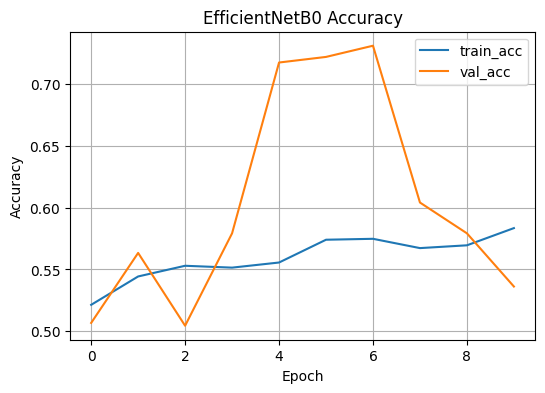

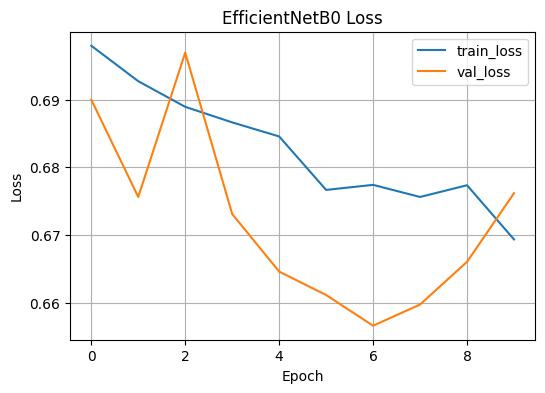

In [23]:
def plot_history(history, title_prefix="Model"):
    hist = history.history
    
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(effnet_history, title_prefix="EfficientNetB0")
